# Segmentation of Medical Scans using VAE's - Part 1/3
This series of notebooks enables reproduceability of our final models and testing results.

The first notebook goes through the process of preparing/preprocessing and understanding our data.

We import some necessary libraries, and check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large. We setup up some global constants.

In [1]:
# For ML
import torch
from torch import Tensor
import torchvision.transforms as Transform

# For reading raw data.
import json
import nibabel as nib

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# For monitoring resource-usage and progress.
from tqdm import tqdm # Install ipywidgets to remove warning.
import psutil
from os.path import join, exists

from utility import CT_Dataset

# Paths
root_dir = '../' # Relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')


# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

# Print some hardware stats. Our datasets is very demanding.
available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


The primary goal is to be able to segment our lung dataset, but we also have datasets for several other organs.

We setup a function to preprocess raw data for an arbitrary organ. The dataset consists of images and labeled images, and a json-file acting as a manifest, specifying paths to those images, along with which ones pair together.

The function will parse the manifest and convert the data to pytorch tensor, to which we apply a resizing transform. The raw images are given in an extremely high resolution, which we do not have the hardware to process. We also normalize the pixel values from 0 to 1.

The function saves after each given organ is processed.

In [2]:
def prep_data(organ, type, resolution):
    # Open manifest file.
    with open(join(raw_data_dir, organ, 'dataset.json')) as f:
        manifest = json.load(f)['training']
    
    # Setup for a process bar, as processing takes a long time.
    bar = tqdm(total=len(manifest))
    bar.set_description('Prepping ' + organ + ' ' + type + 's')
    
    # We define a resizing transform, using the given resolution.
    resize = Transform.Resize((resolution, resolution))

    try: 
        # We initialize an empty tensor, to which we append slices.
        images = torch.zeros((0, resolution, resolution))

        # For each path in the manifest, process data.
        for entry in manifest:
            bar.set_postfix(**{'RAM':round(psutil.virtual_memory()[3]/10e8, 2)})
            bar.update()

            # Load raw data.
            nii_img = nib.load(join(raw_data_dir, organ, entry[type][2:]))

            # Convert to numpy array, then pytorch tensor.
            nii_data = Tensor(nii_img.get_fdata())
            
            # Scale between 0 and 1. Try -1 and 1?
            nii_data -= nii_data.min()
            nii_data /= nii_data.max()

            # Ensure pytorch dimensions.
            nii_data = nii_data.permute(2, 0, 1)
            nii_data = resize(nii_data) # Apply transform.
            images = torch.cat((images, nii_data), 0)
        
        # Save all slices in one pytorch file.
        torch.save(images, join(prep_data_dir, organ + '_' + type + '_slices_' + str(resolution) + '.pt'))

    except KeyboardInterrupt:
        print('Manually stopped.')
    
    bar.close()

We call the preprocessor function, passing in the organs, we wish to train on, and the resolution we want.

In [3]:
lod = 2**8          # Level of detail.
resolution = lod    # 2**8 = 256
do_prep = False     # Toggle to prep data.

organs = ['lung']   #,'colon','pancreas','spleen','liver']

if do_prep:
    for organ in organs:
        prep_data(organ,'image',resolution)
        prep_data(organ,'label',resolution)
else:
    print('Data already prepped.')

Data already prepped.


In the `utility.py` file, we have defined a dataset class, which reads the files, we just saved. We create a dataset, so we can inspect and learn about our data.



In [4]:
# Careful running this. Will take up a lot of RAM.
dataset = CT_Dataset(prep_data_dir, 'lung', 256)

Our dataset class contains a simple function to display a datapoint as the image itself, and its label superimposed on the image. Red indicates cancerous tissue.

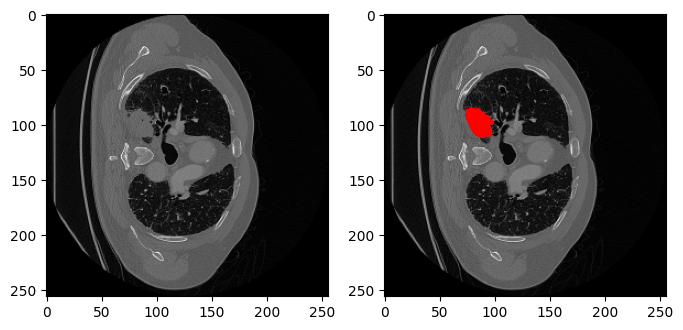

In [13]:
dataset.show_datapoint(900)

It is clear, that each datapoint is a cross-sectional image of a patient lying in a CT-scanner. Going through different datapoints, we see that the positions of the patients are always constant.

We also observe that the tumors, which are labeled, are fairly large, taking up at least 10 (of 256) pixels, which indicate that we may not have to look at finer details.

It is also evident that cancerous tissue contrasts (being closer to a value of 1) to the lungs in particular, which are closer to 0.

Lastly, and naturally, there are many slices, which do not contain cancerous tissue, which may be an issue, if we do not have enough data, where the subject-of-interest is not present.

We found that the data was one-channel, i.e. two dimensions, so our dataset class adds an additional dimension, i.e., the initial number of channels.

In [14]:
image, sample = dataset.__getitem__(900)
np.shape(image)

torch.Size([1, 256, 256])